In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso


In [176]:
bigrams = pd.read_csv("bigram_count.csv")
df = bigrams[pd.notnull(bigrams["score_0"])]
bigrams.head()

,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(watch,live)","(white,house)","(women,act)",name,party,position,score_0,score_115,score_116,state
0,263,0,2,0,0,1,0,0,0,0,...,0,2,0,Abby Finkenauer,D,H,0.000000,NaN,0.000000,Iowa 1st District
1,516,0,7,2,2,3,0,0,0,1,...,4,0,0,Abigail Spanberger,D,H,0.000000,NaN,0.000000,Virginia 7th District
2,242,1,0,0,1,0,0,0,0,0,...,1,1,0,Adam Kinzinger,R,H,0.934426,0.989583,0.730769,Illinois 16th District
3,142,0,0,0,0,0,0,3,0,0,...,0,9,0,Adam Schiff,D,H,0.178862,0.229167,0.000000,California 28th District
4,528,0,0,0,1,0,0,0,0,2,...,0,0,1,Adam Smith,D,H,0.111111,0.144444,0.000000,Washington 9th District


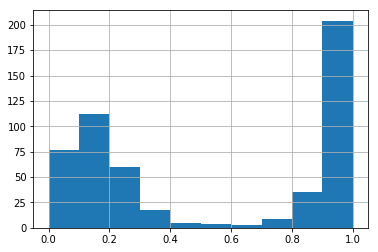

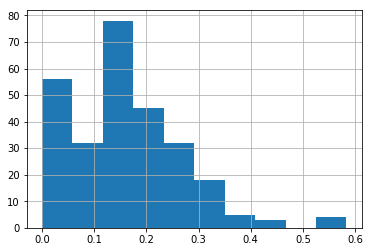

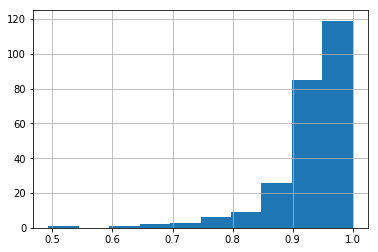

In [177]:
df["score_0"].hist()
plt.show()
df[df["party"]=="D"]["score_0"].hist()
plt.show()
df[df["party"]=="R"]["score_0"].hist()
plt.show()

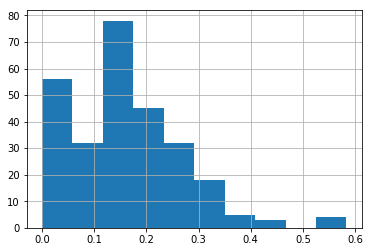

In [179]:
bigrams[bigrams["party"] == "D"]["score_0"].hist()
plt.show()

In [180]:
low = np.round(np.quantile(df["score_0"].values, 0.25), 3)
mid = np.round(np.quantile(df["score_0"].values, 0.50), 3)
upper = np.round(np.quantile(df["score_0"].values, 0.75), 3)

In [181]:
df.loc[df[df["score_0"] <= low].index, "label"] = 0
df.loc[df[(df["score_0"] > low) & (df["score_0"] <= mid)].index, "label"] = 1
df.loc[df[(df["score_0"] > mid) & (df["score_0"] <= upper)].index, "label"] = 2
df.loc[df[df["score_0"] > upper].index, "label"] = 3

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [182]:
bigs = df.columns[1:201]

In [183]:
test = df.iloc[:400]
valid = df.iloc[400:]

X = test[bigs]
Y = test["party"]

x = valid[bigs]
y = valid["party"]


In [184]:
model = LogisticRegression()
model.fit(df[bigs], df["party"])
labs = model.predict(df[bigs])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [185]:
sum(labs != df["party"])

3

In [192]:
model = LinearRegression()
model.fit(test[bigs], test["score_0"])
model.score(test[bigs], test["score_0"])

0.8622351264014726

In [197]:
valid["pred"]  = model.predict(valid[bigs])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [198]:
valid

,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(women,act)",name,party,position,score_0,score_115,score_116,state,label,pred
410,431,0,1,0,0,1,0,0,0,0,...,0,Tom Marino,R,H,0.979167,0.978022,1.000000,Pennsylvania 12th District,3.0,0.236495
411,166,0,0,0,0,0,0,0,0,0,...,0,Tom McClintock,R,H,0.844262,0.810526,0.962963,California 4th District,2.0,0.471865
412,110,0,0,0,0,0,0,0,0,0,...,0,Tom O’Halleran,D,H,0.422764,0.541667,0.000000,Arizona 1st District,2.0,0.537247
413,375,0,0,0,0,1,0,0,0,1,...,0,Tom Reed,R,H,0.932203,0.967033,0.814815,New York 23rd District,2.0,0.510640
414,456,2,0,0,0,0,1,0,2,0,...,0,Tom Rice,R,H,0.942149,0.947368,0.923077,South Carolina 7th District,2.0,0.996833
415,381,0,0,0,0,0,1,0,0,0,...,0,Tom Suozzi,D,H,0.266667,0.344086,0.000000,New York 3rd District,1.0,0.561949
416,143,0,0,0,0,0,3,0,0,1,...,1,Tony Cárdenas,D,H,0.145299,0.184783,0.000000,California 29th District,0.0,0.191612
417,324,1,0,1,2,0,1,0,0,0,...,0,Trent Kelly,R,H,0.942623,0.926316,1.000000,Mississippi 1st District,2.0,0.630473
418,262,0,0,0,0,0,0,0,0,0,...,0,Trey Hollingsworth,R,H,0.876033,0.882979,0.851852,Indiana 9th District,2.0,0.518503
419,405,4,0,0,0,0,0,0,1,1,...,1,Troy Balderson,R,H,0.969697,1.000000,0.962963,Ohio 12th District,3.0,0.618279


In [207]:
df[bigs].sum().sort_values(ascending=False)[:10]

(health,care)             2222
(american,people)         1534
(president,trump)         1455
(look,forward)            1108
(climate,change)          1041
(mueller,report)           916
(town,hall)                893
(looking,forward)          870
(trump,administration)     842
(pre,existing)             685
dtype: int64

In [212]:
r = df[df["party"]=="R"][bigs].sum()
r.head()

(000,jobs)              186
(100,days)               84
(116th,congress)        137
(2019,congressional)     85
(21st,century)           69
dtype: int64

In [213]:
d = df[df["party"]=="D"][bigs].sum()
d.head()

(000,jobs)               18
(100,days)              241
(116th,congress)        158
(2019,congressional)     81
(21st,century)           99
dtype: int64

In [218]:
a = abs(r - d).sort_values(ascending=False)

In [232]:
i = a[a > 200].index.values

In [236]:
model = LinearRegression()
model.fit(test[i], test["score_0"])
model.score(test[i], test["score_0"])
valid["pred"]  = model.predict(valid[i])
valid

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(women,act)",name,party,position,score_0,score_115,score_116,state,label,pred
410,431,0,1,0,0,1,0,0,0,0,...,0,Tom Marino,R,H,0.979167,0.978022,1.000000,Pennsylvania 12th District,3.0,0.461202
411,166,0,0,0,0,0,0,0,0,0,...,0,Tom McClintock,R,H,0.844262,0.810526,0.962963,California 4th District,2.0,0.687172
412,110,0,0,0,0,0,0,0,0,0,...,0,Tom O’Halleran,D,H,0.422764,0.541667,0.000000,Arizona 1st District,2.0,0.591580
413,375,0,0,0,0,1,0,0,0,1,...,0,Tom Reed,R,H,0.932203,0.967033,0.814815,New York 23rd District,2.0,0.743361
414,456,2,0,0,0,0,1,0,2,0,...,0,Tom Rice,R,H,0.942149,0.947368,0.923077,South Carolina 7th District,2.0,1.231828
415,381,0,0,0,0,0,1,0,0,0,...,0,Tom Suozzi,D,H,0.266667,0.344086,0.000000,New York 3rd District,1.0,0.165956
416,143,0,0,0,0,0,3,0,0,1,...,1,Tony Cárdenas,D,H,0.145299,0.184783,0.000000,California 29th District,0.0,0.285843
417,324,1,0,1,2,0,1,0,0,0,...,0,Trent Kelly,R,H,0.942623,0.926316,1.000000,Mississippi 1st District,2.0,0.655184
418,262,0,0,0,0,0,0,0,0,0,...,0,Trey Hollingsworth,R,H,0.876033,0.882979,0.851852,Indiana 9th District,2.0,0.699187
419,405,4,0,0,0,0,0,0,1,1,...,1,Troy Balderson,R,H,0.969697,1.000000,0.962963,Ohio 12th District,3.0,0.771061


In [242]:
rb = r.sort_values(ascending=False)
db = d.sort_values(ascending=False)

In [250]:
s = set(rb.index.values) | set(db.index.values)

In [252]:
model = LinearRegression()
model.fit(test[s], test["score_0"])
print(model.score(test[s], test["score_0"]))
valid["pred"]  = model.predict(valid[s])
valid

0.8622351264014726


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(women,act)",name,party,position,score_0,score_115,score_116,state,label,pred
410,431,0,1,0,0,1,0,0,0,0,...,0,Tom Marino,R,H,0.979167,0.978022,1.000000,Pennsylvania 12th District,3.0,0.236495
411,166,0,0,0,0,0,0,0,0,0,...,0,Tom McClintock,R,H,0.844262,0.810526,0.962963,California 4th District,2.0,0.471865
412,110,0,0,0,0,0,0,0,0,0,...,0,Tom O’Halleran,D,H,0.422764,0.541667,0.000000,Arizona 1st District,2.0,0.537247
413,375,0,0,0,0,1,0,0,0,1,...,0,Tom Reed,R,H,0.932203,0.967033,0.814815,New York 23rd District,2.0,0.510640
414,456,2,0,0,0,0,1,0,2,0,...,0,Tom Rice,R,H,0.942149,0.947368,0.923077,South Carolina 7th District,2.0,0.996833
415,381,0,0,0,0,0,1,0,0,0,...,0,Tom Suozzi,D,H,0.266667,0.344086,0.000000,New York 3rd District,1.0,0.561949
416,143,0,0,0,0,0,3,0,0,1,...,1,Tony Cárdenas,D,H,0.145299,0.184783,0.000000,California 29th District,0.0,0.191612
417,324,1,0,1,2,0,1,0,0,0,...,0,Trent Kelly,R,H,0.942623,0.926316,1.000000,Mississippi 1st District,2.0,0.630473
418,262,0,0,0,0,0,0,0,0,0,...,0,Trey Hollingsworth,R,H,0.876033,0.882979,0.851852,Indiana 9th District,2.0,0.518503
419,405,4,0,0,0,0,0,0,1,1,...,1,Troy Balderson,R,H,0.969697,1.000000,0.962963,Ohio 12th District,3.0,0.618279


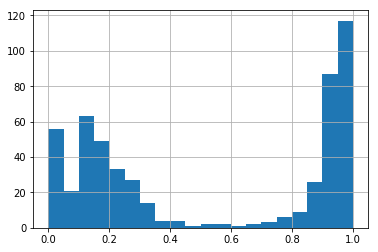

In [254]:
df["score_0"].hist(bins=20)

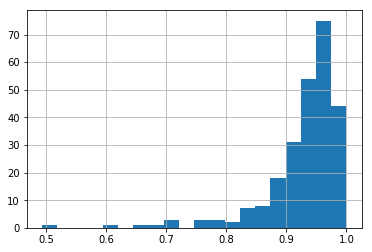

In [258]:
df[df["party"]=="R"]["score_0"].hist(bins=20)

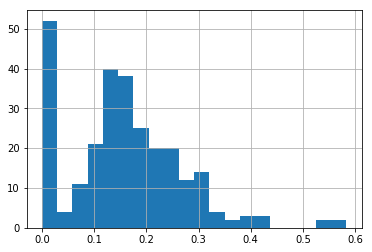

In [259]:
df[df["party"]=="D"]["score_0"].hist(bins=20)

(array([ 60.,  76.,  74.,  48.,  10.,   4.,   5.,   5.,  22., 223.]),
 array([0.        , 0.06931472, 0.13862944, 0.20794415, 0.27725887,
        0.34657359, 0.41588831, 0.48520303, 0.55451774, 0.62383246,
        0.69314718]),
 <a list of 10 Patch objects>)

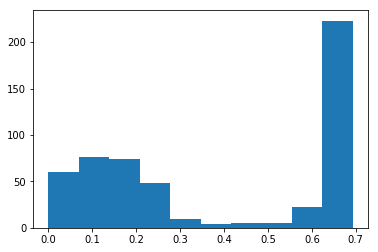

In [267]:
plt.hist(np.log(df["score_0"] + 1))

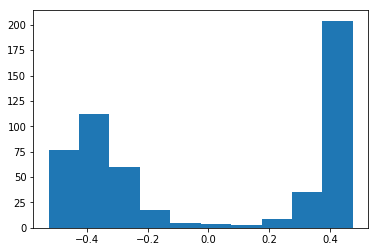

In [278]:
diff = df["score_0"] - df["score_0"].mean()
plt.hist(diff)
plt.show()

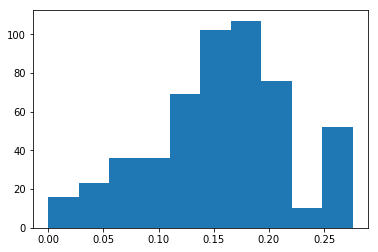

In [282]:
diffsq = diff ** 2
plt.hist(diffsq)
plt.show()

In [284]:
test["diffsq"] = (test["score_0"] - test["score_0"].mean()) ** 2
model = LinearRegression()
model.fit(test[bigs], test["diffsq"])
print(model.score(test[bigs], test["diffsq"]))
valid["pred"]  = model.predict(valid[bigs])
valid

0.5823590622346684


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(women,act)",name,party,position,score_0,score_115,score_116,state,label,pred
410,431,0,1,0,0,1,0,0,0,0,...,0,Tom Marino,R,H,0.979167,0.978022,1.000000,Pennsylvania 12th District,3.0,0.201724
411,166,0,0,0,0,0,0,0,0,0,...,0,Tom McClintock,R,H,0.844262,0.810526,0.962963,California 4th District,2.0,0.125093
412,110,0,0,0,0,0,0,0,0,0,...,0,Tom O’Halleran,D,H,0.422764,0.541667,0.000000,Arizona 1st District,2.0,0.067695
413,375,0,0,0,0,1,0,0,0,1,...,0,Tom Reed,R,H,0.932203,0.967033,0.814815,New York 23rd District,2.0,0.146246
414,456,2,0,0,0,0,1,0,2,0,...,0,Tom Rice,R,H,0.942149,0.947368,0.923077,South Carolina 7th District,2.0,0.183834
415,381,0,0,0,0,0,1,0,0,0,...,0,Tom Suozzi,D,H,0.266667,0.344086,0.000000,New York 3rd District,1.0,0.214950
416,143,0,0,0,0,0,3,0,0,1,...,1,Tony Cárdenas,D,H,0.145299,0.184783,0.000000,California 29th District,0.0,0.176568
417,324,1,0,1,2,0,1,0,0,0,...,0,Trent Kelly,R,H,0.942623,0.926316,1.000000,Mississippi 1st District,2.0,0.229319
418,262,0,0,0,0,0,0,0,0,0,...,0,Trey Hollingsworth,R,H,0.876033,0.882979,0.851852,Indiana 9th District,2.0,0.164616
419,405,4,0,0,0,0,0,0,1,1,...,1,Troy Balderson,R,H,0.969697,1.000000,0.962963,Ohio 12th District,3.0,0.231630


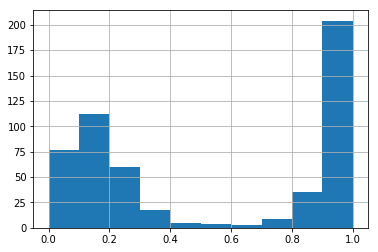

In [285]:
df["score_0"].hist()

In [295]:
test["diffsq"] = (test["score_0"] - test["score_0"].mean()) ** 2
model = Lasso(alpha=0.6)
model.fit(test[bigs], test["diffsq"])
print(model.score(test[bigs], test["diffsq"]))
valid["pred"]  = model.predict(valid[bigs])
valid

0.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(women,act)",name,party,position,score_0,score_115,score_116,state,label,pred
410,431,0,1,0,0,1,0,0,0,0,...,0,Tom Marino,R,H,0.979167,0.978022,1.000000,Pennsylvania 12th District,3.0,0.167604
411,166,0,0,0,0,0,0,0,0,0,...,0,Tom McClintock,R,H,0.844262,0.810526,0.962963,California 4th District,2.0,0.167604
412,110,0,0,0,0,0,0,0,0,0,...,0,Tom O’Halleran,D,H,0.422764,0.541667,0.000000,Arizona 1st District,2.0,0.167604
413,375,0,0,0,0,1,0,0,0,1,...,0,Tom Reed,R,H,0.932203,0.967033,0.814815,New York 23rd District,2.0,0.167604
414,456,2,0,0,0,0,1,0,2,0,...,0,Tom Rice,R,H,0.942149,0.947368,0.923077,South Carolina 7th District,2.0,0.167604
415,381,0,0,0,0,0,1,0,0,0,...,0,Tom Suozzi,D,H,0.266667,0.344086,0.000000,New York 3rd District,1.0,0.167604
416,143,0,0,0,0,0,3,0,0,1,...,1,Tony Cárdenas,D,H,0.145299,0.184783,0.000000,California 29th District,0.0,0.167604
417,324,1,0,1,2,0,1,0,0,0,...,0,Trent Kelly,R,H,0.942623,0.926316,1.000000,Mississippi 1st District,2.0,0.167604
418,262,0,0,0,0,0,0,0,0,0,...,0,Trey Hollingsworth,R,H,0.876033,0.882979,0.851852,Indiana 9th District,2.0,0.167604
419,405,4,0,0,0,0,0,0,1,1,...,1,Troy Balderson,R,H,0.969697,1.000000,0.962963,Ohio 12th District,3.0,0.167604


In [330]:
model = LinearRegression()
model.fit(test[cols], test["score_0"])
print(model.score(test[cols], test["score_0"]))
valid["pred"]  = model.predict(valid[cols])
valid

0.8159377264063528


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(women,act)",name,party,position,score_0,score_115,score_116,state,label,pred
410,431,0,1,0,0,1,0,0,0,0,...,0,Tom Marino,R,H,0.979167,0.978022,1.000000,Pennsylvania 12th District,3.0,0.261401
411,166,0,0,0,0,0,0,0,0,0,...,0,Tom McClintock,R,H,0.844262,0.810526,0.962963,California 4th District,2.0,0.541431
412,110,0,0,0,0,0,0,0,0,0,...,0,Tom O’Halleran,D,H,0.422764,0.541667,0.000000,Arizona 1st District,2.0,0.513739
413,375,0,0,0,0,1,0,0,0,1,...,0,Tom Reed,R,H,0.932203,0.967033,0.814815,New York 23rd District,2.0,0.564039
414,456,2,0,0,0,0,1,0,2,0,...,0,Tom Rice,R,H,0.942149,0.947368,0.923077,South Carolina 7th District,2.0,1.093074
415,381,0,0,0,0,0,1,0,0,0,...,0,Tom Suozzi,D,H,0.266667,0.344086,0.000000,New York 3rd District,1.0,0.405041
416,143,0,0,0,0,0,3,0,0,1,...,1,Tony Cárdenas,D,H,0.145299,0.184783,0.000000,California 29th District,0.0,0.315668
417,324,1,0,1,2,0,1,0,0,0,...,0,Trent Kelly,R,H,0.942623,0.926316,1.000000,Mississippi 1st District,2.0,0.695971
418,262,0,0,0,0,0,0,0,0,0,...,0,Trey Hollingsworth,R,H,0.876033,0.882979,0.851852,Indiana 9th District,2.0,0.563892
419,405,4,0,0,0,0,0,0,1,1,...,1,Troy Balderson,R,H,0.969697,1.000000,0.962963,Ohio 12th District,3.0,0.856971


In [313]:
rmax = []
dmax = []
for i in rm.index.values:
    if i not in sdm:
        rmax.append(i)
        
for i in dm.index.values:
    if i not in srm:
        dmax.append(i)

In [318]:
rm["(look,forward)"]

662

In [361]:
reps = []
dems = []

rt = []
dt = []
rscores = []
for b in bigs:
    rtotal = df[df["party"]=="R"][b].sum()
    dtotal = df[df["party"]=="D"][b].sum()
    total = rtotal + dtotal
    rscore = rtotal / total
    if (rscore >= 0.60):
        reps.append(b)
    elif (rscore <= 0.40):
        dems.append(b)
    rt.append(rtotal)
    dt.append(dtotal)
    rscores.append(rscore)

In [360]:
dfr = df[reps].sum(1)
dfd = df[dems].sum(1)
df2 = pd.DataFrame({"reps": dfr, "dems": dfd, "party": df["party"], "score": df["score_0"]})
df2


,reps,dems,party,score
0,3,41,D,0.000000
1,4,50,D,0.000000
2,31,16,R,0.934426
3,6,119,D,0.178862
4,6,97,D,0.111111
5,43,36,R,0.942623
6,0,14,D,0.089431
7,13,54,D,0.138211
8,0,23,D,0.293103
9,10,145,D,0.126050


In [ ]:
model = LinearRegression()
model.fit(test[cols], test["score_0"])
print(model.score(test[cols], test["score_0"]))
valid["pred"]  = model.predict(valid[cols])
valid

In [391]:
bigsdf = pd.DataFrame({"bigram": bigs, "rtotal": rt, "dtotal": dt, "rscore": rscores})
bigsdf["r_lean"] = np.where((bigsdf["rscore"] >= 0.60) & (bigsdf["rscore"] < 0.75), 1, 0)
bigsdf["r_solid"] = np.where(bigsdf["rscore"] >= 0.75, 1, 0)
bigsdf["d_lean"] = np.where((bigsdf["rscore"] <= 0.40) & (bigsdf["rscore"] > 0.25), 1, 0)
bigsdf["d_solid"] = np.where(bigsdf["rscore"] <= 0.25, 1, 0)

In [402]:
df.head()

,custom_id,"(000,jobs)","(100,days)","(116th,congress)","(2019,congressional)","(21st,century)","(6,million)","(9,11)","(abortion,survivors)","(access,quality)",...,"(white,house)","(women,act)",name,party,position,score_0,score_115,score_116,state,label
0,263,0,2,0,0,1,0,0,0,0,...,2,0,Abby Finkenauer,D,H,0.000000,NaN,0.000000,Iowa 1st District,0.0
1,516,0,7,2,2,3,0,0,0,1,...,0,0,Abigail Spanberger,D,H,0.000000,NaN,0.000000,Virginia 7th District,0.0
2,242,1,0,0,1,0,0,0,0,0,...,1,0,Adam Kinzinger,R,H,0.934426,0.989583,0.730769,Illinois 16th District,2.0
3,142,0,0,0,0,0,0,3,0,0,...,9,0,Adam Schiff,D,H,0.178862,0.229167,0.000000,California 28th District,1.0
4,528,0,0,0,1,0,0,0,0,2,...,0,1,Adam Smith,D,H,0.111111,0.144444,0.000000,Washington 9th District,0.0


In [445]:
r_lean = df[bigsdf[bigsdf["r_lean"] == 1]["bigram"].values].sum(1)
r_solid = df[bigsdf[bigsdf["r_solid"] == 1]["bigram"].values].sum(1)
d_lean = df[bigsdf[bigsdf["d_lean"] == 1]["bigram"].values].sum(1)
d_solid = df[bigsdf[bigsdf["d_solid"] == 1]["bigram"].values].sum(1)


df_leans = pd.DataFrame({
    "custom_id": df["custom_id"], "name": df["name"], "party": df["party"], "position": df["position"], 
    "r_lean": r_lean, "r_solid": r_solid, "d_lean": d_lean, "d_solid": d_solid, "label": label,
    "score": df["score_0"]
})

df_leans.loc[(df_leans["score"] >= 0.5) & (df_leans["score"] < 0.85), "label"] = "leans_r"
df_leans.loc[(df_leans["score"] >= 0.85), "label"] = "solid_r"
df_leans.loc[(df_leans["score"] < 0.50) & (df_leans["score"] >= 0.15), "label"] = "leans_d"
df_leans.loc[(df_leans["score"] < 0.15), "label"] = "solid_d"
df_leans.head()


,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,label,score
0,263,Abby Finkenauer,D,H,3,0,15,26,solid_d,0.000000
1,516,Abigail Spanberger,D,H,2,2,31,19,solid_d,0.000000
2,242,Adam Kinzinger,R,H,13,18,14,2,solid_r,0.934426
3,142,Adam Schiff,D,H,2,4,74,45,leans_d,0.178862
4,528,Adam Smith,D,H,3,3,31,66,solid_d,0.111111


In [446]:
test = df_leans.iloc[:400]
valid = df_leans.iloc[400:]

cols = ["r_lean", "r_solid", "d_lean", "d_solid"]
model = LinearRegression()
model.fit(test[cols], test["score"])
print(model.score(test[cols], test["score"]))
valid["pred"]  = model.predict(valid[cols])
valid

0.6860276069891874


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,label,score,pred
410,431,Tom Marino,R,H,5,4,19,27,solid_r,0.979167,0.428240
411,166,Tom McClintock,R,H,6,4,7,1,leans_r,0.844262,0.634598
412,110,Tom O’Halleran,D,H,8,1,15,32,leans_d,0.422764,0.415448
413,375,Tom Reed,R,H,11,19,17,25,solid_r,0.932203,0.651845
414,456,Tom Rice,R,H,31,58,33,19,solid_r,0.942149,1.268935
415,381,Tom Suozzi,D,H,4,1,28,12,leans_d,0.266667,0.478635
416,143,Tony Cárdenas,D,H,0,3,27,51,solid_d,0.145299,0.178313
417,324,Trent Kelly,R,H,23,7,4,1,solid_r,0.942623,0.894604
418,262,Trey Hollingsworth,R,H,2,0,7,5,solid_r,0.876033,0.519658
419,405,Troy Balderson,R,H,14,14,13,7,solid_r,0.969697,0.778090


In [447]:
test = df_leans.iloc[:400]
valid = df_leans.iloc[400:]

cols = ["r_lean", "r_solid", "d_lean", "d_solid"]
model = LogisticRegression()
model.fit(test[cols], test["label"])
valid["pred"]  = model.predict(valid[cols])
valid

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,label,score,pred
410,431,Tom Marino,R,H,5,4,19,27,solid_r,0.979167,solid_d
411,166,Tom McClintock,R,H,6,4,7,1,leans_r,0.844262,solid_r
412,110,Tom O’Halleran,D,H,8,1,15,32,leans_d,0.422764,solid_d
413,375,Tom Reed,R,H,11,19,17,25,solid_r,0.932203,solid_r
414,456,Tom Rice,R,H,31,58,33,19,solid_r,0.942149,solid_r
415,381,Tom Suozzi,D,H,4,1,28,12,leans_d,0.266667,solid_d
416,143,Tony Cárdenas,D,H,0,3,27,51,solid_d,0.145299,solid_d
417,324,Trent Kelly,R,H,23,7,4,1,solid_r,0.942623,solid_r
418,262,Trey Hollingsworth,R,H,2,0,7,5,solid_r,0.876033,solid_d
419,405,Troy Balderson,R,H,14,14,13,7,solid_r,0.969697,solid_r


In [449]:
sum(valid["label"] != valid["pred"])

58

In [460]:
df_leans2 = df_leans.copy()
df_leans2["r_lean"] = np.log(df_leans["r_lean"] + 1)
df_leans2["d_lean"] = np.log(df_leans["d_lean"] + 1)
df_leans2["r_solid"] = np.log(df_leans["r_solid"] + 1)
df_leans2["d_solid"] = np.log(df_leans["d_solid"] + 1)
df_leans2.head()

,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,label,score
0,263,Abby Finkenauer,D,H,1.386294,0.000000,2.772589,3.295837,solid_d,0.000000
1,516,Abigail Spanberger,D,H,1.098612,1.098612,3.465736,2.995732,solid_d,0.000000
2,242,Adam Kinzinger,R,H,2.639057,2.944439,2.708050,1.098612,solid_r,0.934426
3,142,Adam Schiff,D,H,1.098612,1.609438,4.317488,3.828641,leans_d,0.178862
4,528,Adam Smith,D,H,1.386294,1.386294,3.465736,4.204693,solid_d,0.111111


In [461]:
test = df_leans2.iloc[:400]
valid = df_leans2.iloc[400:]

cols = ["r_lean", "r_solid", "d_lean", "d_solid"]
model = LinearRegression()
model.fit(test[cols], test["score"])
print(model.score(test[cols], test["score"]))
valid["pred"]  = model.predict(valid[cols])
valid

0.8032280706204749


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,custom_id,name,party,position,r_lean,r_solid,d_lean,d_solid,label,score,pred
410,431,Tom Marino,R,H,1.791759,1.609438,2.995732,3.332205,solid_r,0.979167,0.386457
411,166,Tom McClintock,R,H,1.945910,1.609438,2.079442,0.693147,leans_r,0.844262,0.877373
412,110,Tom O’Halleran,D,H,2.197225,0.693147,2.772589,3.496508,leans_d,0.422764,0.255034
413,375,Tom Reed,R,H,2.484907,2.995732,2.890372,3.258097,solid_r,0.932203,0.646170
414,456,Tom Rice,R,H,3.465736,4.077537,3.526361,2.995732,solid_r,0.942149,0.916246
415,381,Tom Suozzi,D,H,1.609438,0.693147,3.367296,2.564949,leans_d,0.266667,0.382113
416,143,Tony Cárdenas,D,H,0.000000,1.386294,3.332205,3.951244,solid_d,0.145299,0.115672
417,324,Trent Kelly,R,H,3.178054,2.079442,1.609438,0.693147,solid_r,0.942623,1.031596
418,262,Trey Hollingsworth,R,H,1.098612,0.000000,2.079442,1.791759,solid_r,0.876033,0.389149
419,405,Troy Balderson,R,H,2.708050,2.708050,2.639057,2.079442,solid_r,0.969697,0.835195


In [469]:
sum(df[df["party"]=="R"][bigs].sum().values) / len(df[df["party"]=="R"])

92.63492063492063

In [470]:
sum(df[df["party"]=="D"][bigs].sum().values) / len(df[df["party"]=="D"])

121.04395604395604